### Dataset https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import random
import numpy as np
from tqdm import tqdm
import gc
from sklearn import metrics

from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import logging

from torchsummary import summary

#add utils module to sys path
import sys
sys.path.append('../')

from utils import training, datasets
from utils.datasets import EnergyDataset
import pathlib

import pickle

In [21]:
root = os.getcwd()
dataset_path = os.path.join(root,'dataset/household_power_consumption.txt')
assert os.path.exists(dataset_path), f'path to dataset does not exist, path = {dataset_path}'

In [22]:
df = pd.read_csv(dataset_path, sep =';')
print(df.shape)
df.head()

(2075259, 9)


C:\Users\nguye\AppData\Local\Temp\ipykernel_7184\10537488.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_path, sep =';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [24]:
df.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


### Convert other float coumns to numbers

In [25]:
def to_float(x):
    return None if x == '?' else float(x)

for c in df.columns:
    try:
        df[c] = df[c].apply(to_float)
    except Exception as e:
        print(f"error in column {c}, error {e}")



error in column Date, error could not convert string to float: '16/12/2006'
error in column Time, error could not convert string to float: '17:24:00'


### Convert date and time column to timestamp

In [26]:
def extract_detail_datetime(datetime_fmt):
    date, time = datetime_fmt.split(' ')
    day, month, year = date.split("/")
    hour, minute, second = time.split(":")
    month = int(month)
    day = int(day)
    year = int(year)
    hour = int(hour)
    minute = int(minute)
    second = int(second)

    dt = datetime(
        month = month,
        day = day,
        year = year,
        hour = hour,
        minute = minute,
        second = second
    )

    return month, day, year, hour, minute, second, dt.timestamp()

date_time_col = df["Date"].str.cat(df['Time'], sep = ' ')
month_col, day_col, year_col, hour_col, minute_col, second_col, timestamp_col = [],[],[],[],[],[],[]

for row in date_time_col:
    month, day, year, hour, minute, second, timestamp = extract_detail_datetime(row)
    month_col.append(month)
    day_col.append(day)
    year_col.append(year)
    hour_col.append(hour)
    minute_col.append(minute)
    second_col.append(second)
    timestamp_col.append(timestamp)


df['Month'] = month_col
df['Day'] = day_col
df['Year'] = year_col
df['Hour'] = hour_col
df['Minute'] = minute_col
df['Timestamp'] = timestamp_col

In [27]:
nacount = df.isna().sum()
percent = (df.isna().sum() / df.shape[0]) * 100.0

missing = pd.concat([nacount, percent], axis = 1).rename(columns = {0:'Missing', 1:'Percentage'})
print(missing)


                       Missing  Percentage
Date                         0    0.000000
Time                         0    0.000000
Global_active_power      25979    1.251844
Global_reactive_power    25979    1.251844
Voltage                  25979    1.251844
Global_intensity         25979    1.251844
Sub_metering_1           25979    1.251844
Sub_metering_2           25979    1.251844
Sub_metering_3           25979    1.251844
Month                        0    0.000000
Day                          0    0.000000
Year                         0    0.000000
Hour                         0    0.000000
Minute                       0    0.000000
Timestamp                    0    0.000000


### Dropping NA values since they don't take up too much of the dataset

In [28]:
df = df.dropna()
#check NAs again
nacount = df.isna().sum()
percent = (df.isna().sum() / df.shape[0]) * 100.0

missing = pd.concat([nacount, percent], axis = 1).rename(columns = {0:'Missing', 1:'Percentage'})
print(missing)

                       Missing  Percentage
Date                         0         0.0
Time                         0         0.0
Global_active_power          0         0.0
Global_reactive_power        0         0.0
Voltage                      0         0.0
Global_intensity             0         0.0
Sub_metering_1               0         0.0
Sub_metering_2               0         0.0
Sub_metering_3               0         0.0
Month                        0         0.0
Day                          0         0.0
Year                         0         0.0
Hour                         0         0.0
Minute                       0         0.0
Timestamp                    0         0.0


In [30]:
print(df.shape)
df.head(100)

(2049280, 15)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month,Day,Year,Hour,Minute,Timestamp
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,12,16,2006,17,24,1.166308e+09
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,12,16,2006,17,25,1.166308e+09
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,12,16,2006,17,26,1.166308e+09
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,12,16,2006,17,27,1.166308e+09
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,12,16,2006,17,28,1.166308e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16/12/2006,18:59:00,4.224,0.090,231.96,18.2,0.0,1.0,16.0,12,16,2006,18,59,1.166314e+09
96,16/12/2006,19:00:00,4.070,0.088,231.99,17.4,0.0,1.0,17.0,12,16,2006,19,0,1.166314e+09
97,16/12/2006,19:01:00,3.612,0.090,232.36,15.6,0.0,2.0,16.0,12,16,2006,19,1,1.166314e+09
98,16/12/2006,19:02:00,3.458,0.090,232.71,14.8,0.0,1.0,17.0,12,16,2006,19,2,1.166314e+09


### EDA

In [18]:
print(df.columns)

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')


In [19]:
display_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']

0
1
2
3
4
5
6
7


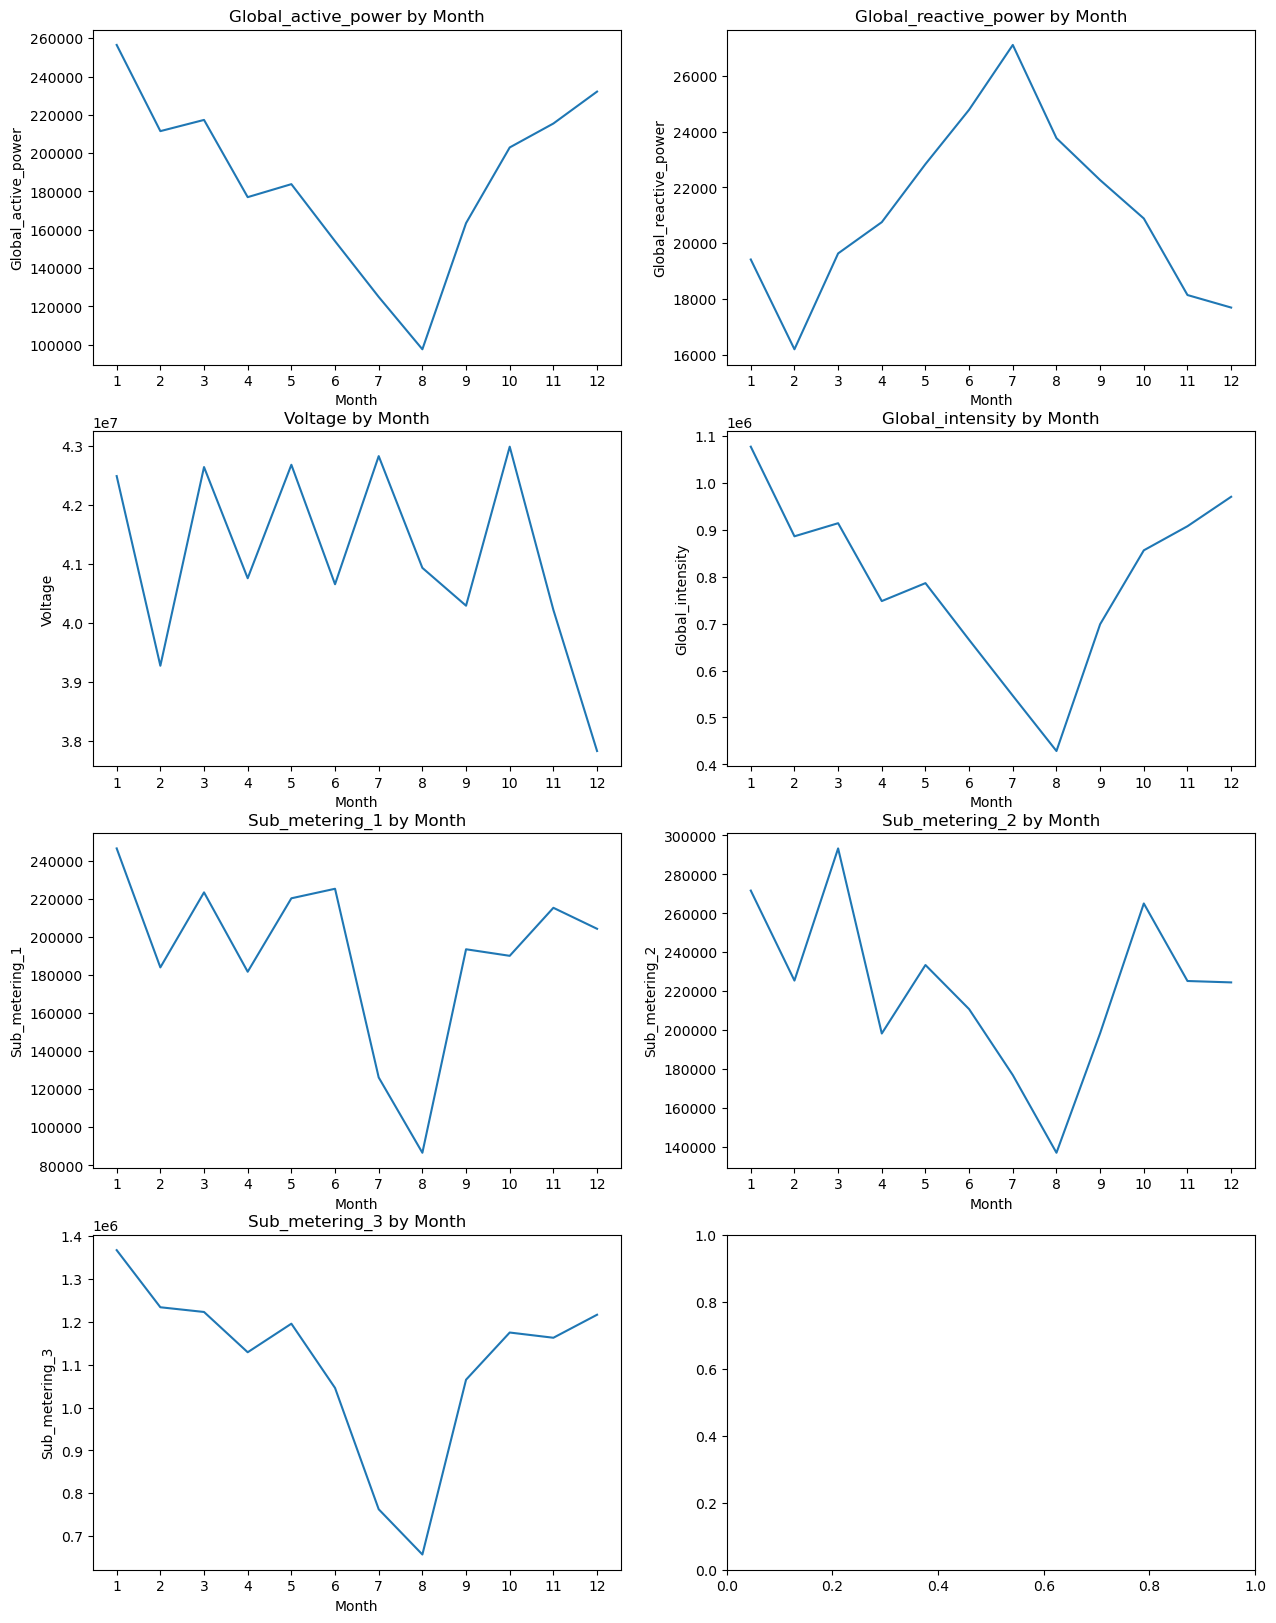

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Month,,,,,,,
1,256510.910,19423.232,42484013.54,1076886.2,246732.0,271705.0,1367272.0
2,211513.754,16209.808,39273124.37,885965.2,184142.0,225524.0,1234072.0
3,217367.670,19640.004,42636810.67,913854.8,223613.0,293338.0,1223080.0
4,177045.106,20758.774,40754399.10,747984.0,181860.0,198365.0,1129112.0
5,183832.962,22837.432,42675687.17,786197.6,220498.0,233514.0,1195741.0


In [38]:
group_by_year = df.groupby('Month')[display_cols].sum()
row_n = 4
col_n = 2

fig, axes = plt.subplots(row_n,col_n, figsize = (15,20))

for row in range(row_n):
    for col in range(col_n):
        i = row * col_n + col
        print(i)
        if i >= len(display_cols): break
        ax = axes[row][col]

        sns.lineplot(group_by_year[display_cols[i]], ax = ax)
        ax.set_xticks(list(group_by_year.index))
        ax.set_title(f"{display_cols[i]} by Month")
plt.show()
group_by_year.head()

In [ ]:
group_by_month = df.groupby(['Year', 'Month'])[display_cols].sum()

# sns.lineplot(group_by_month.loc['2007']['Global_active_power'])
# print(group_by_month[df['Year']])
# print(group_by_month.index)
year_col, month_col = [],[]

for year, month in group_by_month.index:
    year_col.append(year)
    month_col.append(month)

group_by_month['Year'] = year_col 
group_by_month['Month'] = month_col 

group_by_month.head(20)


Global_active_power  Global_reactive_power      Voltage  \
Year Month                                                            
2006 12               41813.282               2889.436   5309773.22   
2007 1                69011.862               5922.396  10753521.91   
     2                56488.886               4581.608   9697260.78   
     3                58862.192               5122.184  10736280.75   
     4                35181.466               4688.994   9450794.83   
     5                44008.872               5148.894  10498362.16   
     6                35682.828               6317.980  10309151.25   
     7                29703.830               5674.062  10578509.55   
     8                34096.460               5033.644  10616283.84   
     9                41872.606               5443.416  10342642.60   
     10               49276.370               4171.170  10700881.41   
     11               55918.644               4170.904  10405070.38   
     12               72604.170               4950.484  10790396.33   
2008 1                65169.382               3908.238  10742211.50   
     2                49331.072               3639.688  10046857.96   
     3                55590.594               4531.466  10772523.43   
     4                48209.992               5361.760  10420755.46   
     5                45721.860               6896.588  10729543.15   
     6                42943.972               6550.438  10323489.14   
     7                35477.418               6551.446  10702890.14   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Year Month                                                                     
2006 12             176594.8         27460.0         48712.0        162951.0   
2007 1              292241.2         56433.0         79274.0        329578.0   
     2              238463.6         47584.0         64604.0        270274.0   
     3              248772.2         60769.0        104762.0        290361.0   
     4              151026.2         42078.0         38417.0        189503.0   
     5              191838.8         75737.0         72132.0        229448.0   
     6              155518.4         59672.0         69939.0        188851.0   
     7              131040.4         43052.0         55733.0        154815.0   
     8              147804.6         36251.0         49711.0        225442.0   
     9              180334.8         52841.0         75277.0        226375.0   
     10             208779.8         43218.0         87914.0        256080.0   
     11             235253.8         50823.0         73666.0        299690.0   
     12             304418.2         74090.0         82931.0        362423.0   
2008 1              275945.6         61761.0         62911.0        312175.0   
     2              207710.2         40192.0         56646.0        255918.0   
     3              233677.6         63110.0         79277.0        279670.0   
     4              202913.0         47080.0         70871.0        295678.0   
     5              195697.2         53084.0         58907.0        290620.0   
     6              185819.0         68728.0         63449.0        290103.0   
     7              154611.8         47313.0         44416.0        227228.0   

            Year  Month  
Year Month               
2006 12     2006     12  
2007 1      2007      1  
     2      2007      2  
     3      2007      3  
     4      2007      4  
     5      2007      5  
     6      2007      6  
     7      2007      7  
     8      2007      8  
     9      2007      9  
     10     2007     10  
     11     2007     11  
     12     2007     12  
2008 1      2008      1  
     2      2008      2  
     3      2008      3  
     4      2008      4  
     5      2008      5  
     6      2008      6  
     7      2008      7

Text(0.5, 1.0, 'Globale Active Power by Month for Every Year')

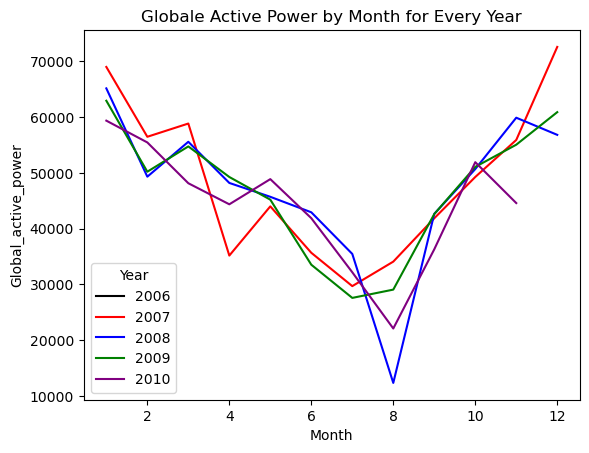

In [ ]:
sns.lineplot(data = group_by_month, x = 'Month', y ='Global_active_power', hue = 'Year', palette=['black', 'red', 'blue', 'green', 'purple'])
plt.title("Globale Active Power by Month for Every Year")

In [39]:
# print(set(df['Year']))
# group_by_month.head(100)

###  Training base RNN model 

In [ ]:
#Final processed df 
print('df shape = ', df.shape)
df.head()

df shape =  (2049280, 15)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month,Day,Year,Hour,Minute,Timestamp
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,12,16,2006,17,24,1.166308e+09
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,12,16,2006,17,25,1.166308e+09
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,12,16,2006,17,26,1.166308e+09
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,12,16,2006,17,27,1.166308e+09
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,12,16,2006,17,28,1.166308e+09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049280 entries, 0 to 2075258
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
 9   Month                  int64  
 10  Day                    int64  
 11  Year                   int64  
 12  Hour                   int64  
 13  Minute                 int64  
 14  Timestamp              float64
dtypes: float64(8), int64(5), object(2)
memory usage: 250.2+ MB


In [ ]:
print(df.columns)
df.describe()

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Month', 'Day', 'Year', 'Hour', 'Minute',
       'Timestamp'],
      dtype='object')


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month,Day,Year,Hour,Minute,Timestamp
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,6.454433e+00,1.571245e+01,2.008425e+03,1.150391e+01,2.950043e+01,1.228195e+09
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,3.423209e+00,8.801670e+00,1.124388e+00,6.925189e+00,1.731790e+01,3.578735e+07
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.006000e+03,0.000000e+00,0.000000e+00,1.166308e+09
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,8.000000e+00,2.007000e+03,5.000000e+00,1.500000e+01,1.197283e+09
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,1.600000e+01,2.008000e+03,1.200000e+01,3.000000e+01,1.228026e+09
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,9.000000e+00,2.300000e+01,2.009000e+03,1.800000e+01,4.500000e+01,1.259026e+09
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.200000e+01,3.100000e+01,2.010000e+03,2.300000e+01,5.900000e+01,1.290823e+09


In [ ]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month,Day,Year,Hour,Minute,Timestamp
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,12,16,2006,17,24,1.166308e+09
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,12,16,2006,17,25,1.166308e+09
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,12,16,2006,17,26,1.166308e+09
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,12,16,2006,17,27,1.166308e+09
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,12,16,2006,17,28,1.166308e+09


### Splitting dataset to train, valid, test

### Experiments
1. dropping month, day, hour, minute and use timestamp instead
2. normalize the columns
3. set the timestep to 100

In [79]:
class EnergyDataset(Dataset):

    def __init__(self, df, target, cols, to_type = None, timestep = 15, log_level = logging.DEBUG):
        super().__init__()
        df.reset_index(inplace = True)

        self.logger = logging.getLogger()
        self.logger.setLevel(log_level)

        test_df = df.reset_index()
        features = test_df[cols].drop(target, axis = 1)

        #normalzie the features
        features = (features - features.min())/(features.max() - features.min())

        labels = test_df[target]
        if to_type == None:
            to_type = lambda x: torch.tensor(np.array(x)).to(torch.float)

        self.X, self.y = self._make_sequence(features, labels, timestep = timestep, to_type = to_type)
        self.logger.debug(f'X shape =  {self.X.shape}')
        self.logger.debug(f'y shape =  {self.y.shape}')
        self.logger
        gc.collect()
    
    def _make_sequence(self, features, labels, timestep, to_type = None):
        '''
        @params:
            N: lenght of array
        @returns:
            X: features, shape = (d, timestep)
            y: labels, shape = (d)
            NOTE: d = N - timestep
        '''
        X = []
        y = [] 
        N = len(features)
        if timestep >= N: 
            if to_type:
                return to_type(features[:-1]), to_type(labels[-1]) 
            else:
                return features[:-1], labels[-1] 

        self.logger.info('building sequences ... ')
        for i in tqdm(range(N - timestep)):
            X.append(features[i: i + timestep])
            y.append(labels[i + timestep])
        self.logger.info('done building sequences')

        if to_type:
            return to_type(X), to_type(y)
        else:
            return X, y
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)
    
    def get_dataloader(self, **kwargs):
        return DataLoader(self, **kwargs)

### Baseline

In [ ]:
# #Split train test
# x_train, x_valid_test, y_train, y_valid_test = train_test_split(features, labels, random_state = 42, shuffle = True)
# x_valid, x_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, random_state = 42, shuffle = True, test_size = 0.5)

# print("X train shape = ", x_train.shape)
# print("y train shape = ", y_train.shape)
# print("X valid shape = ", x_valid.shape)
# print("y valid shape = ", y_valid.shape)
# print("X test shape = ", x_test.shape)
# print("y test shape = ", y_test.shape)

In [75]:
cols = ['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Month']
target = 'Month'

train_df = df[cols].copy()

classes = set(train_df[target].values)
num_classes = len(classes)
print("clases = ", classes)
print('num classes = ', num_classes)

clases =  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
num classes =  12


In [76]:
train_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,12
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,12
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,12
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,12
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,12


In [78]:
# train_df = (train_df - train_df.min())/(train_df.max() - train_df.min())
# train_df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,9.194415e-02,8.900322e-02,5.699469e-01,9.186223e-02,1.274913e-02,1.623150e-02,2.083370e-01,4.958575e-01
std,9.571738e-02,8.109495e-02,1.046845e-01,9.220739e-02,6.992081e-02,7.277533e-02,2.721663e-01,3.112009e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.100308e-02,3.453237e-02,5.101777e-01,2.489627e-02,0.000000e+00,0.000000e+00,0.000000e+00,1.818182e-01
50%,4.761905e-02,7.194245e-02,5.754443e-01,4.979253e-02,0.000000e+00,0.000000e+00,3.225806e-02,4.545455e-01
75%,1.314503e-01,1.395683e-01,6.361874e-01,1.286307e-01,0.000000e+00,1.250000e-02,5.483871e-01,7.272727e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [80]:
to_tensor = lambda x: torch.tensor(np.array(x)).to(torch.float)
dataset = EnergyDataset(train_df[:100000], target = target, cols = cols, to_type = to_tensor)
print(len(dataset))

INFO:root:building sequences ... 
100%|██████████| 99985/99985 [00:04<00:00, 23693.75it/s]
INFO:root:done building sequences
DEBUG:root:X shape =  torch.Size([99985, 15, 7])
DEBUG:root:y shape =  torch.Size([99985])


99985


In [86]:
#Test the correctness 
dataloader = dataset.get_dataloader(batch_size = 32)

print(len(dataloader))
for _ in range(3000):
    X,y = next(iter(dataloader))

print('X shape = ', X.shape)
print('y shape = ', y.shape)

print(X)
print(y)

3125
X shape =  torch.Size([32, 15, 7])
y shape =  torch.Size([32])
tensor([[[0.4364, 0.4783, 0.4023,  ..., 0.0000, 0.0128, 0.8500],
         [0.5605, 0.4989, 0.3594,  ..., 0.0000, 0.0128, 0.8000],
         [0.5621, 0.5698, 0.3474,  ..., 0.0000, 0.0256, 0.8500],
         ...,
         [0.5458, 0.5469, 0.3368,  ..., 0.0000, 0.0128, 0.8000],
         [0.5506, 0.4554, 0.3339,  ..., 0.0000, 0.0256, 0.8500],
         [0.4188, 0.4828, 0.4165,  ..., 0.0000, 0.0128, 0.8500]],

        [[0.5605, 0.4989, 0.3594,  ..., 0.0000, 0.0128, 0.8000],
         [0.5621, 0.5698, 0.3474,  ..., 0.0000, 0.0256, 0.8500],
         [0.5636, 0.5744, 0.3633,  ..., 0.0000, 0.0128, 0.8500],
         ...,
         [0.5506, 0.4554, 0.3339,  ..., 0.0000, 0.0256, 0.8500],
         [0.4188, 0.4828, 0.4165,  ..., 0.0000, 0.0128, 0.8500],
         [0.3461, 0.3227, 0.4839,  ..., 0.0000, 0.0000, 0.8500]],

        [[0.5621, 0.5698, 0.3474,  ..., 0.0000, 0.0256, 0.8500],
         [0.5636, 0.5744, 0.3633,  ..., 0.0000, 0.0128,

In [67]:
batch_size = 32
train_dataset, valid_dataset, test_dataset = training.train_val_test_split(dataset)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
print('train dataloader len = ', len(train_dataloader))
print('valid dataloader len = ', len(valid_dataloader))
print('test dataloader len = ', len(test_dataloader))


train dataloader len =  2188
valid dataloader len =  469
test dataloader len =  469


In [55]:
X, y = next(iter(train_dataloader))
print('X shape = ', X.shape)
print('y shape = ', y.shape)

X shape =  torch.Size([32, 100, 7])
y shape =  torch.Size([32])


In [32]:
#save dataset
with open('dataset.pkl', 'wb') as file:
    pickle.dump(dataset, file)

#load dataset
# with open('dataset.pkl', 'rb') as file:
#     dataset = pickle.load(file)

In [70]:
class ClassificationRNN(nn.Module):

    def __init__(self, input_size, output_size, num_hiddens = 300, num_layers = 5, dropout = 0.5):
        super().__init__()

        self.input_size = input_size
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.dropout = dropout

        self.rnn_blocks = nn.Sequential()

        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = num_hiddens,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True
            )
        
        self.dense = nn.LazyLinear(output_size)
    
    def forward(self, X):
        outputs, state = self.rnn(X)
        Y = self.dense(outputs[:,-1])
        return Y

In [71]:

X, y =next(iter(train_dataloader))
print('X shape = ', X.shape)
batch, num_step, input_size = X.shape
model = ClassificationRNN(input_size = input_size)

y_pred = model(X)

print('y_pred shape = ', y_pred.shape)



X shape =  torch.Size([32, 15, 7])


TypeError: __init__() missing 1 required positional argument: 'output_size'